In [1]:
from glob import glob
import numpy as np
from numpy import array as ar
from skimage.io import imsave, imread
import matplotlib.pyplot as plt
import os
from fish.image.vol import unfilter_flat, dff
from scipy.ndimage.filters import median_filter
%matplotlib inline

In [2]:
def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

In [3]:
base_dir = '/groups/ahrens/ahrenslab/davis/data/epi/20161222/8dpf_cy252xcy293_opto_5/'
fs_im = 2
roi_fname = glob(base_dir +'*ROI*')[0]
im_dir = base_dir + 'ims/'
im_fnames = glob(im_dir + 't*')
order = np.argsort(ar([int(f.split('.')[0].split(os.path.sep)[-1].split('_')[-1]) for f in im_fnames]))
im_fnames = ar(im_fnames)[order]
print(len(im_fnames))

600


In [4]:
ims = ar([imread(f) for f in im_fnames]).astype('float32')
t_roi = slice(0, None)
ims = ims[t_roi]
stim_roi = plt.imread(roi_fname)

## Clean up the images with median filter

In [5]:
%%time
ims = np.array([median_filter(i, size=3) for i in ims])

CPU times: user 1min 8s, sys: 1.09 s, total: 1min 9s
Wall time: 1min 9s


In [6]:
import pyqtgraph as pq
%gui qt
pq.image(ims)

In [7]:
def remove_stim_artifact(data, stim_times):
    offset = np.diff(data[stim_times[-1]:stim_times[-1] + 2])
    data_ = data.copy()
    data_[stim_times[0]:stim_times[-1]+1] += offset
    return data_ 

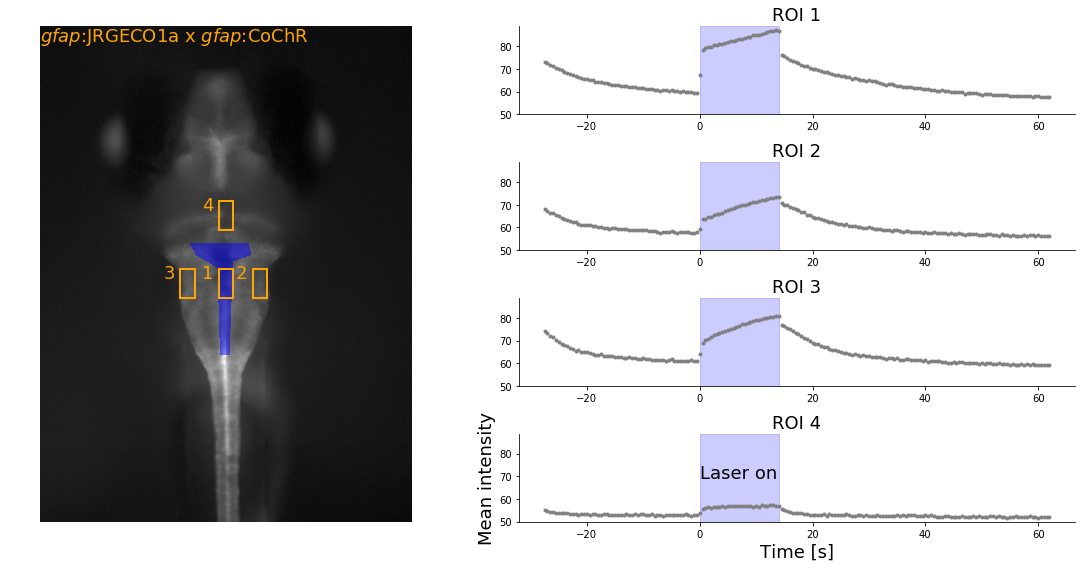

In [12]:
from skimage.color import grey2rgb
from skimage.exposure import rescale_intensity
from scipy.ndimage.filters import median_filter
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(nrows=4, ncols=2, width_ratios=(1,1))

plr = slice(400, 580)
laser_timing = np.array([455, 483])
roi_fl = [(slice(500,560), slice(370,400)),
          (slice(500,560), slice(440,470)),
          (slice(500,560), slice(290,320)),
          (slice(360, 420), slice(370, 400))]

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 18,
        }


resc = rescale_intensity(ims[plr].mean(0),out_range=(0, 255)).astype('uint8')
gsc = grey2rgb(resc)
stim_roi_ = stim_roi.copy()
stim_roi_[:,:,-1] = stim_roi_[:,:,0] * .5
stim_roi_[:,:,:2] = 0

fig=plt.figure(figsize=(16,8))
axs_im = fig.add_subplot(gs[:,0])
axs_im.imshow(gsc)
axs_im.imshow(stim_roi_)
anno_im = axs_im.annotate('$\itgfap$:JRGECO1a x $\itgfap$:CoChR', (0,30), color='orange', fontsize=18)

rects = [Rectangle((r[1].start, r[0].start), r[1].stop-r[1].start, r[0].stop-r[0].start, fill=None, color='orange', linewidth=2) for r in roi_fl]
annos = []
for ind, re in enumerate(rects):
    axs_im.add_patch(re)
    annos.append(axs_im.annotate(str(1 + ind), re.get_xy(), xytext=np.array(re.get_xy()) - [35, -20], color='orange', fontsize=18))

axs_im.axis('off')

mydff = lambda v: dff(v, window=120, percentile=5, baseline_offset=0)
axs_ts = []
for cur_roi in range(len(roi_fl)):
    if cur_roi == 0:
        axs_ts.append(fig.add_subplot(gs[cur_roi,1]))
    else:
        axs_ts.append(fig.add_subplot(gs[cur_roi,1], sharey=axs_ts[-1]))
    cur_axs = axs_ts[-1]
    roi_ts = ims[plr][:,roi_fl[cur_roi][0], roi_fl[cur_roi][1]].mean((1,2))
    # remove the stimulation artifact
    #roi_ts = remove_stim_artifact(roi_ts, laser_timing - plr.start)
    x_axis = (np.arange(roi_ts.shape[0]) - (laser_timing[0] - plr.start)) / fs_im

    cur_axs.plot(x_axis,roi_ts,'.', color='grey')
    laser_on_span = (0, np.diff(laser_timing)//fs_im)
    cur_axs.axvspan(*laser_on_span, zorder=0, color='b', alpha=.2)
    axs_format(cur_axs)
    cur_axs.set_title('ROI {0}'.format(cur_roi + 1), fontdict=font)
    if cur_roi == len(roi_fl)-1:
        cur_axs.set_ylabel('Mean intensity', fontdict=font)
        cur_axs.set_xlabel('Time [s]', fontdict=font)
axs_ts[-1].annotate('Laser on', (laser_on_span[0], np.diff(axs_ts[-1].get_ylim())/2 + axs_ts[-1].get_ylim()[0] ), fontsize=18)    
plt.tight_layout()
plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/opto_stim_imaging_example.pdf')

(-0.5, 767.5, 1023.5, -0.5)

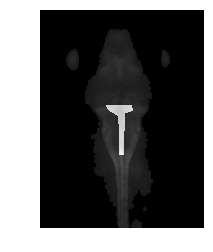

In [38]:
from skimage.morphology import binary_opening, disk

ref = ims[0:10].mean(0).astype('float32')
thr = 30
mask = ref > thr
mask = binary_opening(mask, disk(10))
plt.imshow((ref * mask) + roi[:,:,0], cmap='gray')
plt.axis('off')

In [39]:
threshed = ar([i[mask] for i in ims])

In [46]:
%%time
dff_vol = ar([dff(f, window=50, baseline_offset=.2, percentile=10) for f in threshed.T])

CPU times: user 1min 47s, sys: 4.2 s, total: 1min 52s
Wall time: 2min 2s


In [41]:
dff_vol = ar([unfilter_flat(d, mask) for d in dff_vol.T]).astype('float32')

In [42]:
dff_vol.shape

(600, 1024, 768)

In [43]:
pq.image(dff_vol)

In [11]:
from scipy.stats import zscore
tmp_inds = (slice(0,None), slice(roi_inds[0][0], roi_inds[0][-1]), slice(roi_inds[1][0], roi_inds[1][-1]))
plt.plot(zscore(ims[tmp_inds].mean((1,2))))
#plt.plot(zscore(dff_vol[tmp_inds].mean((1,2))))
plt.xlabel('Time [s]')

NameError: name 'roi_inds' is not defined

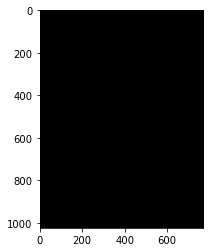

In [15]:
plt.imshow(dff_vol[0], cmap='gray')